In [1]:
import numpy as np
import pandas as pd
import math
import random
import datetime as dt
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [2]:
msft = pd.read_csv("./msft.csv")
msft.head()

,Date,Close/Last,Volume,Open,High,Low
0,11/27/2024,$422.99,18332440,$425.105,$427.2299,$422.02
1,11/26/2024,$427.99,23458890,$419.585,$429.0414,$418.85
2,11/25/2024,$418.79,27691090,$418.38,$421.08,$414.85
3,11/22/2024,$417.00,24814630,$411.365,$417.40,$411.06
4,11/21/2024,$412.87,20780160,$419.50,$419.78,$410.2887


In [3]:
msft.rename(columns={"Close/Last":"Close"}, inplace=True)
msft['Date'] = pd.to_datetime(msft['Date'])
msft.set_index(['Date'], inplace=True)

In [4]:
msft.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 254 entries, 2024-11-27 to 2023-11-27
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Close   254 non-null    object
 1   Volume  254 non-null    int64 
 2   Open    254 non-null    object
 3   High    254 non-null    object
 4   Low     254 non-null    object
dtypes: int64(1), object(4)
memory usage: 11.9+ KB


In [5]:
msft['Close'] = msft['Close'].replace('[^.0-9]', '', regex=True).astype(float)

In [6]:
msft = msft.iloc[::-1]
msft.head()

,Close,Volume,Open,High,Low
Date,,,,,
2023-11-27,378.61,22179230,$376.78,$380.64,$376.20
2023-11-28,382.70,20453110,$378.35,$383.00,$378.16
2023-11-29,378.85,28963400,$383.76,$384.30,$377.44
2023-11-30,378.91,30554420,$378.49,$380.09,$375.47
2023-12-01,374.51,33040470,$376.76,$378.16,$371.31


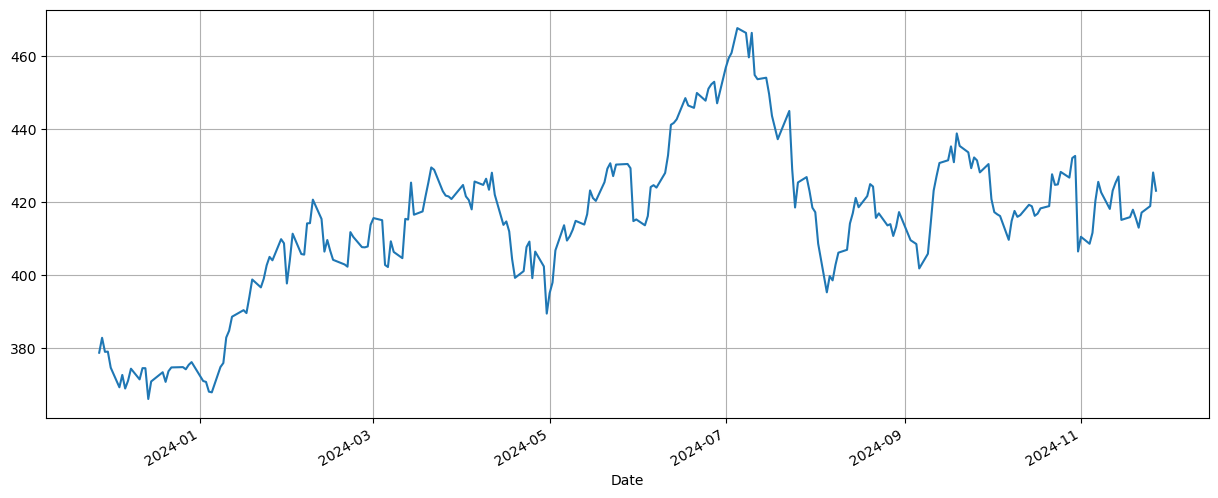

In [7]:
plt.figure(figsize=(15, 6))
msft['Close'].plot()
plt.grid(True)

In [8]:
def get_n_last_days(dataframe, column, n_days):
    return dataframe[column].iloc[-n_days:] 

def plot_n_last_days(dataframe, column, n_days):
    """
    Plot the last n days of a stock price.
    
    Parameters:
    - dataframe (pd.DataFrame): The DataFrame containing the stock data.
    - column (str): The column name representing the stock price.
    - n_days (int): The number of last days to plot.
    """
    plt.figure(figsize=(10, 5))
    
    # Slice the last n_days
    if n_days > len(dataframe):
        print(f"Warning: n_days ({n_days}) is greater than the length of the dataframe ({len(dataframe)}). Plotting all available data.")
        plot_data = dataframe[column]
    else:
        plot_data = get_n_last_days(dataframe, column, n_days)
    
    plot_data.plot(style='r-', marker='o')
    plt.title(f'{column} Google Stock Price - Last {n_days} Days')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(alpha=0.3)
    
    plt.show()

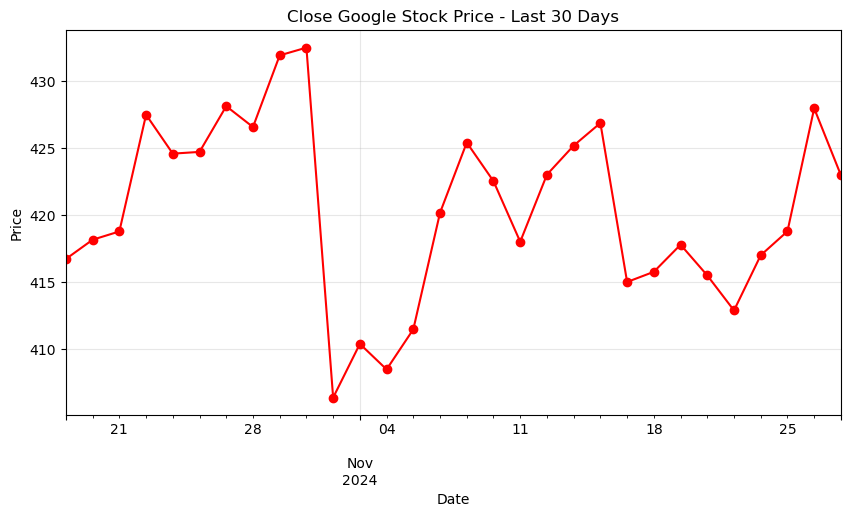

In [9]:
plot_n_last_days(msft, 'Close', 30)

In [10]:
decompose = seasonal_decompose(msft['Close'], model='multiplicative', period=60)
estimated_trend = decompose.trend
estimated_seasonal = decompose.seasonal
estimated_residual = decompose.resid

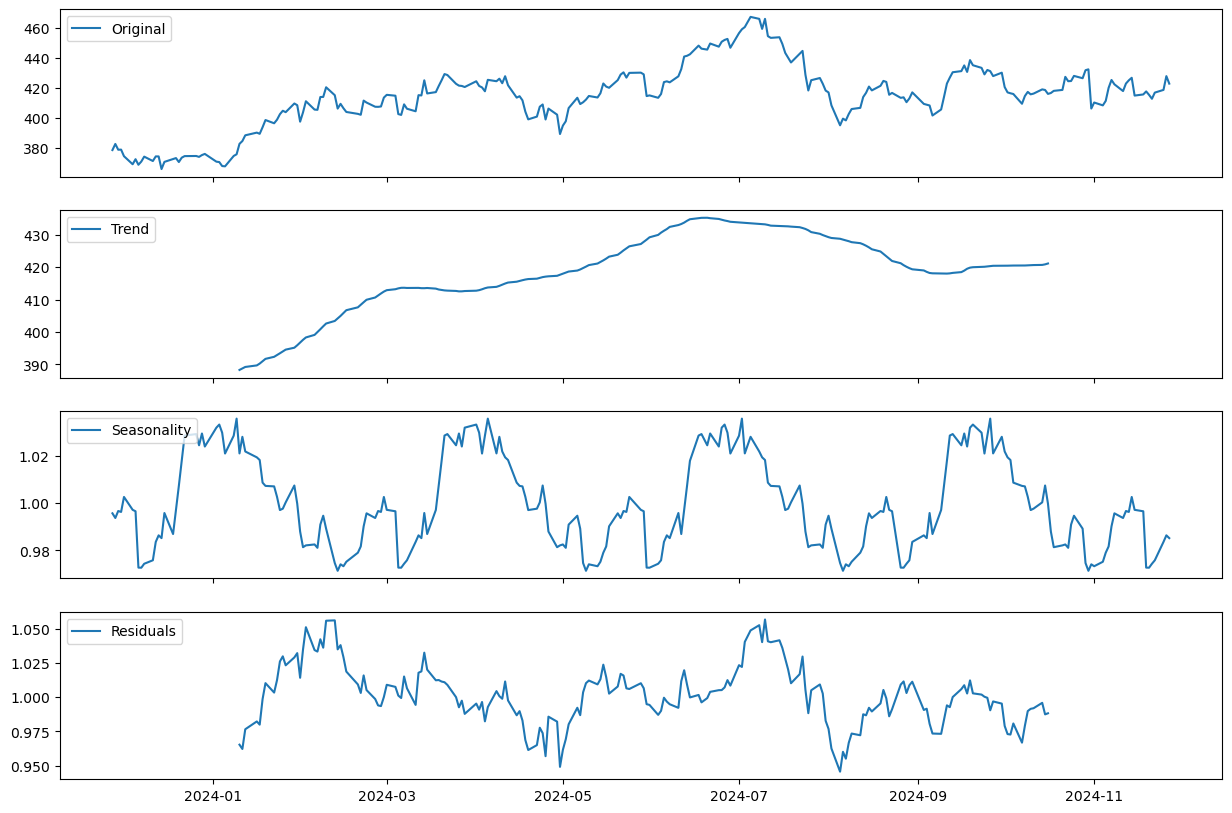

In [11]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(msft['Close'], label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual, label='Residuals')
axes[3].legend(loc='upper left');

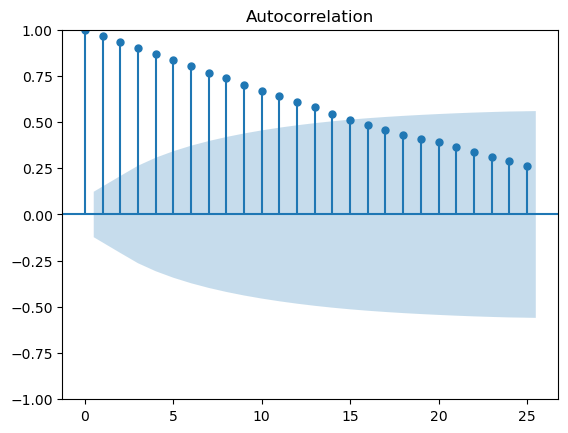

In [12]:
plot_acf(msft['Close'])
plt.show()

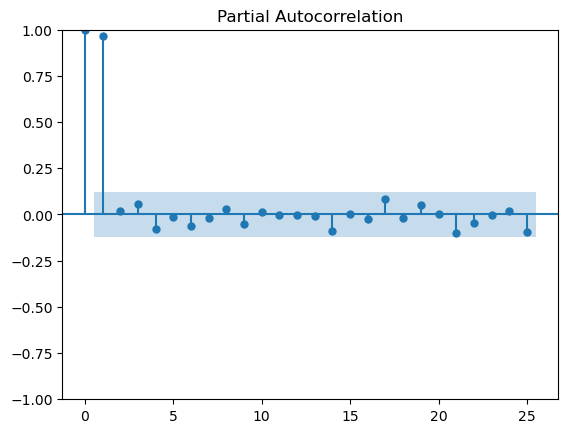

In [13]:
plot_pacf(msft['Close'])
plt.show()

In [14]:
adf_result = adfuller(msft['Close'])
print("ADF Test Results:")
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Critical Values: {adf_result[4]}")

# KPSS Test
kpss_result = kpss(msft['Close'], regression='ct')  # 'c' for constant, 'ct' for constant and trend
print("\nKPSS Test Results:")
print(f"KPSS Statistic: {kpss_result[0]}")
print(f"p-value: {kpss_result[1]}")
print(f"Critical Values: {kpss_result[3]}")

ADF Test Results:
ADF Statistic: -2.297620169264795
p-value: 0.17273666314359926
Critical Values: {'1%': -3.4564641849494113, '5%': -2.873032730098417, '10%': -2.572894516864816}

KPSS Test Results:
KPSS Statistic: 0.3328767429893526
p-value: 0.01
Critical Values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}


In [15]:
msft['Close_diff'] = msft['Close'].diff()
msft.head()

,Close,Volume,Open,High,Low,Close_diff
Date,,,,,,
2023-11-27,378.61,22179230,$376.78,$380.64,$376.20,NaN
2023-11-28,382.70,20453110,$378.35,$383.00,$378.16,4.09
2023-11-29,378.85,28963400,$383.76,$384.30,$377.44,-3.85
2023-11-30,378.91,30554420,$378.49,$380.09,$375.47,0.06
2023-12-01,374.51,33040470,$376.76,$378.16,$371.31,-4.40


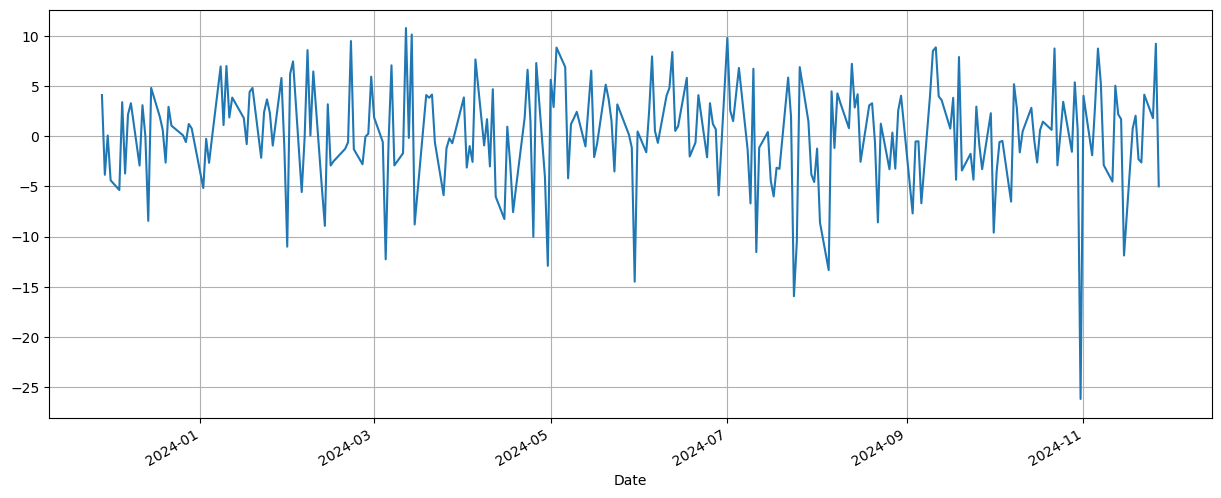

In [16]:
plt.figure(figsize=(15, 6))
msft['Close_diff'].plot()
plt.grid(True)

In [17]:
# Configuraciones para los modelos SARIMAX
sarimax_configs = [
    {'order': (1, 1, 1), 'seasonal_order': (1, 1, 1, 12)},  # Configuración 1
    {'order': (2, 1, 2), 'seasonal_order': (1, 0, 1, 12)},  # Configuración 2
    {'order': (3, 1, 0), 'seasonal_order': (0, 1, 1, 12)},  # Configuración 3
    {'order': (1, 1, 1), 'seasonal_order': (1, 1, 0, 12)}   # Configuración 4
]

In [18]:
train_size = int(len(msft) * 0.9)

train_data = msft['Close'].iloc[:train_size]
test_data = msft['Close'].iloc[train_size:]

In [19]:
best_model = None
best_config = None
best_mae = float('inf')  # Inicializamos con un valor muy alto para MAE
best_rmse = float('inf') 

# Asumimos que 'data' contiene la serie temporal
results = []

for config in sarimax_configs:
    print(f"Evaluando configuración: {config}")
    
    # Crear y entrenar el modelo
    model = SARIMAX(train_data, 
                    order=config['order'], 
                    seasonal_order=config['seasonal_order'])
    fitted_model = model.fit(disp=False)
    
    # Generar predicciones en el conjunto de entrenamiento
    # Aquí se utiliza el rango de las predicciones, desde el inicio del conjunto de prueba hasta el final
    predictions = fitted_model.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
    
    # Calcular métricas de error
    mae = mean_absolute_error(test_data, predictions)
    rmse = np.sqrt(mean_squared_error(test_data, predictions))
    
    # Almacenar resultados
    results.append({
        'config': config,
        'model': fitted_model,
        'mae': mae,
        'rmse': rmse
    })

    if mae < best_mae:  # Si el modelo actual tiene menor MAE
        best_mae = mae
        best_rmse = rmse
        best_model = fitted_model
        best_config = config

    print(f"MAE: {mae}, RMSE: {rmse}")

Evaluando configuración: {'order': (1, 1, 1), 'seasonal_order': (1, 1, 1, 12)}
MAE: 11.16655960118631, RMSE: 13.106658876115105
Evaluando configuración: {'order': (2, 1, 2), 'seasonal_order': (1, 0, 1, 12)}
MAE: 8.180297109557973, RMSE: 10.253171276924537
Evaluando configuración: {'order': (3, 1, 0), 'seasonal_order': (0, 1, 1, 12)}
MAE: 11.78737163588638, RMSE: 13.752269715614013
Evaluando configuración: {'order': (1, 1, 1), 'seasonal_order': (1, 1, 0, 12)}
MAE: 7.306451799652505, RMSE: 9.293764502931511


In [20]:
for result in results:
    print(f"Config: {result['config']}, MAE: {result['mae']:.2f}, RMSE: {result['rmse']:.2f}")

Config: {'order': (1, 1, 1), 'seasonal_order': (1, 1, 1, 12)}, MAE: 11.17, RMSE: 13.11
Config: {'order': (2, 1, 2), 'seasonal_order': (1, 0, 1, 12)}, MAE: 8.18, RMSE: 10.25
Config: {'order': (3, 1, 0), 'seasonal_order': (0, 1, 1, 12)}, MAE: 11.79, RMSE: 13.75
Config: {'order': (1, 1, 1), 'seasonal_order': (1, 1, 0, 12)}, MAE: 7.31, RMSE: 9.29


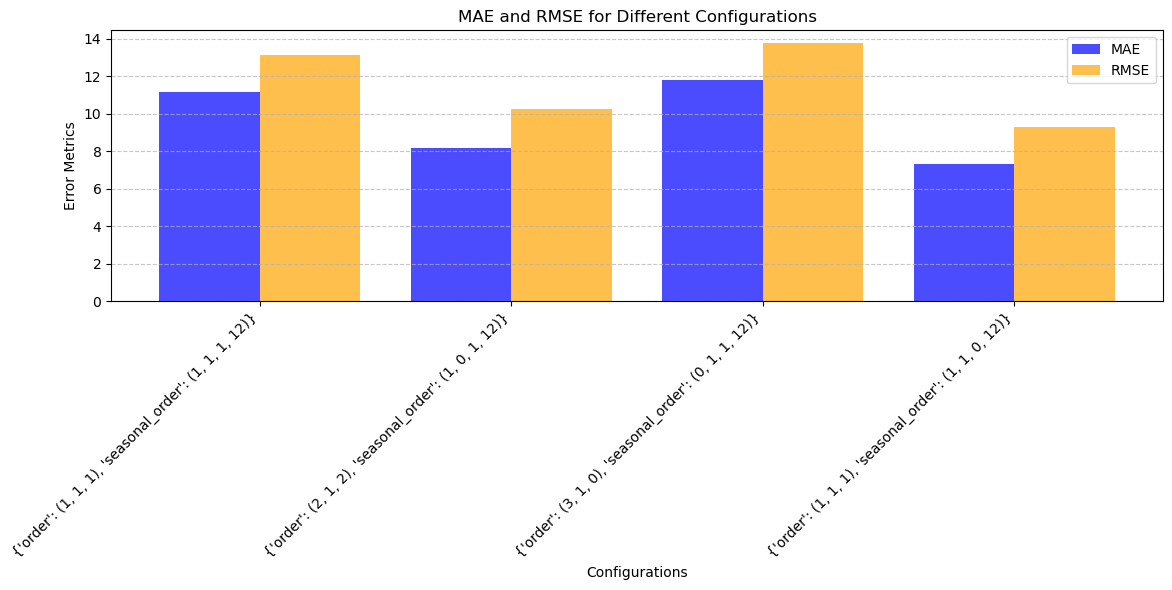

In [21]:
configs = [str(result['config']) for result in results]  # Convert config dicts to strings for display
maes = [result['mae'] for result in results]
rmses = [result['rmse'] for result in results]

# Define the bar width and positions
x = np.arange(len(configs))  # The label locations (indices for configurations)
bar_width = 0.4  # Width of each bar

# Create the bar plot
plt.figure(figsize=(12, 6))
plt.bar(x - bar_width / 2, maes, width=bar_width, label='MAE', color='blue', alpha=0.7)
plt.bar(x + bar_width / 2, rmses, width=bar_width, label='RMSE', color='orange', alpha=0.7)

# Add labels, legend, and title
plt.xlabel('Configurations')
plt.ylabel('Error Metrics')
plt.title('MAE and RMSE for Different Configurations')
plt.xticks(x, configs, rotation=45, ha='right')  # Rotate configuration labels for better readability
plt.legend()
plt.tight_layout()

# Show the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [22]:
print(f"Best order: {best_config['order']}, Best seasonal order: {best_config['seasonal_order']}")

Best order: (1, 1, 1), Best seasonal order: (1, 1, 0, 12)


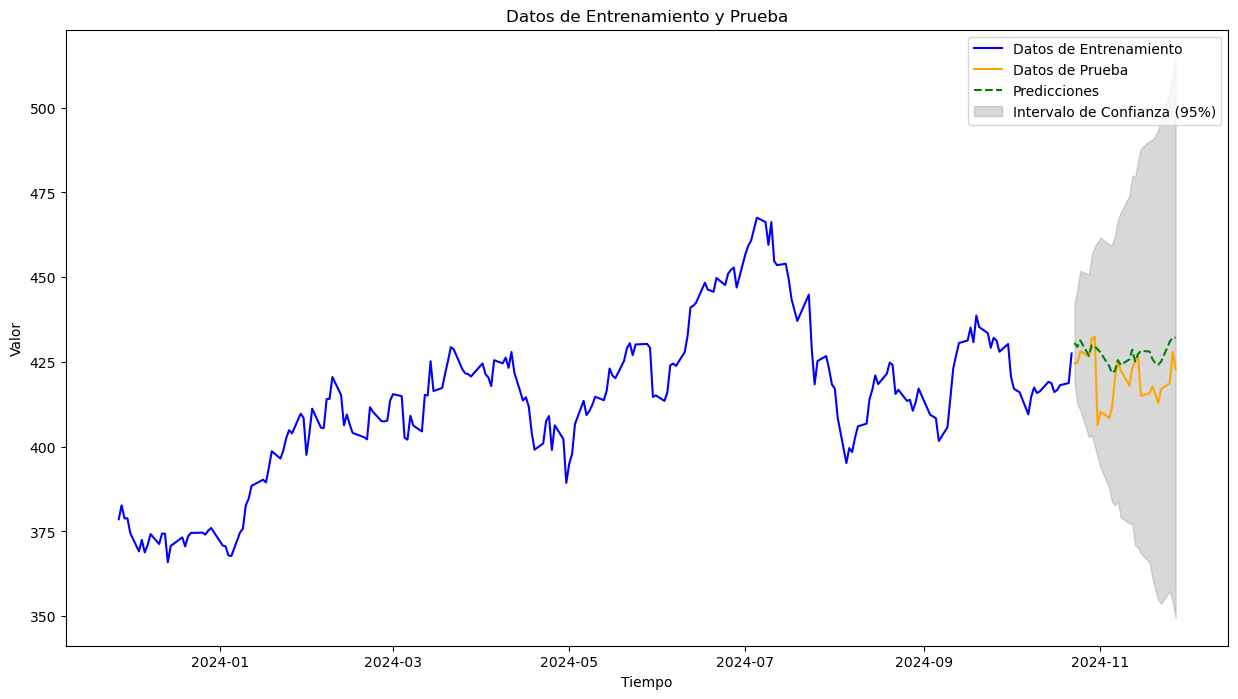

In [23]:
train_index = train_data.index
test_index = test_data.index

plt.figure(figsize=(15, 8))
# Graficar los datos de entrenamiento en color azul
plt.plot(train_index, train_data, label="Datos de Entrenamiento", color='blue')

# Graficar los datos de prueba en color naranja
plt.plot(test_index, test_data, label="Datos de Prueba", color='orange')

model = SARIMAX(train_data, order=best_config['order'], seasonal_order=best_config['seasonal_order'])
fitted_model = model.fit(disp=False)

# Generar las predicciones con sus intervalos de confianza usando get_forecast
forecast_steps = len(test_data)
forecast = fitted_model.get_forecast(steps=forecast_steps)
predictions = forecast.predicted_mean
conf_int = forecast.conf_int()

# Graficar las predicciones con el intervalo de confianza
plt.plot(test_index, predictions, label="Predicciones", color='green', linestyle='--')

# Graficar los intervalos de confianza como área sombreada
plt.fill_between(test_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3, label="Intervalo de Confianza (95%)")
# Opcionalmente, puedes agregar títulos y etiquetas
plt.title("Datos de Entrenamiento y Prueba")
plt.xlabel("Tiempo")
plt.ylabel("Valor")
plt.legend()

plt.show()

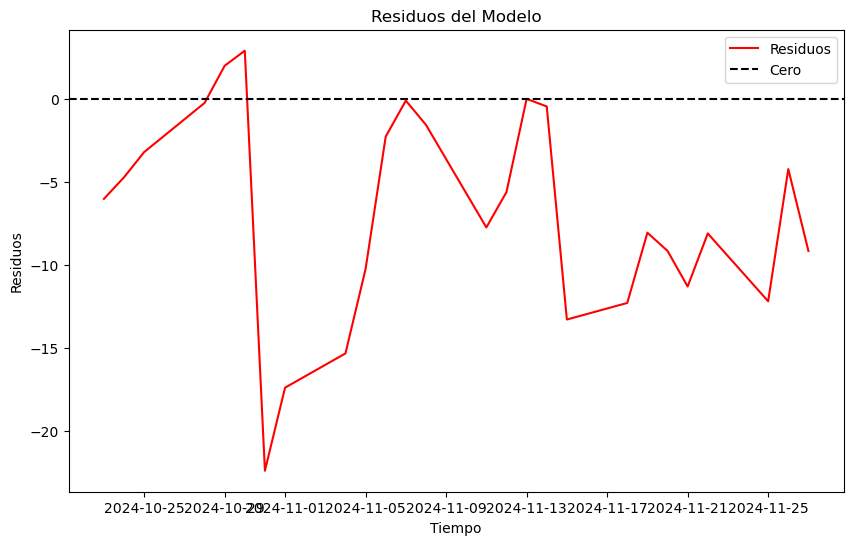

In [24]:
residuals = test_data.values - predictions.values

plt.figure(figsize=(10, 6))
plt.plot(test_index, residuals, label="Residuos", color='red')
plt.axhline(y=0, color='black', linestyle='--', label="Cero")
plt.title("Residuos del Modelo")
plt.xlabel("Tiempo")
plt.ylabel("Residuos")
plt.legend()
plt.show()

## Deep learning

In [26]:
def create_dataset(data, n_input, n_output):
    X, y = [], []
    for i in range(len(data) - n_input - n_output + 1):
        # Secuencia de entrada de tamaño n_input
        X.append(data[i:i+n_input])
        # Secuencia de salida (predicción) de tamaño n_output
        y.append(data[i+n_input:i+n_input+n_output])
    return np.array(X), np.array(y)

In [27]:
configs = [
    {'input_steps': 2, 'forecast_steps': 1},
    {'input_steps': 2, 'forecast_steps': 2},
    {'input_steps': 4, 'forecast_steps': 1},
    {'input_steps': 4, 'forecast_steps': 2},
    {'input_steps': 10, 'forecast_steps': 1}
]

In [28]:
scaler = StandardScaler()
scaled_msft = scaler.fit_transform(msft[['Close']])

In [29]:
train_size = int(len(msft) * 0.8)

Evaluando configuración: {'input_steps': 2, 'forecast_steps': 1}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
MAE: 3.659051488759564, RMSE: 5.511264700308934


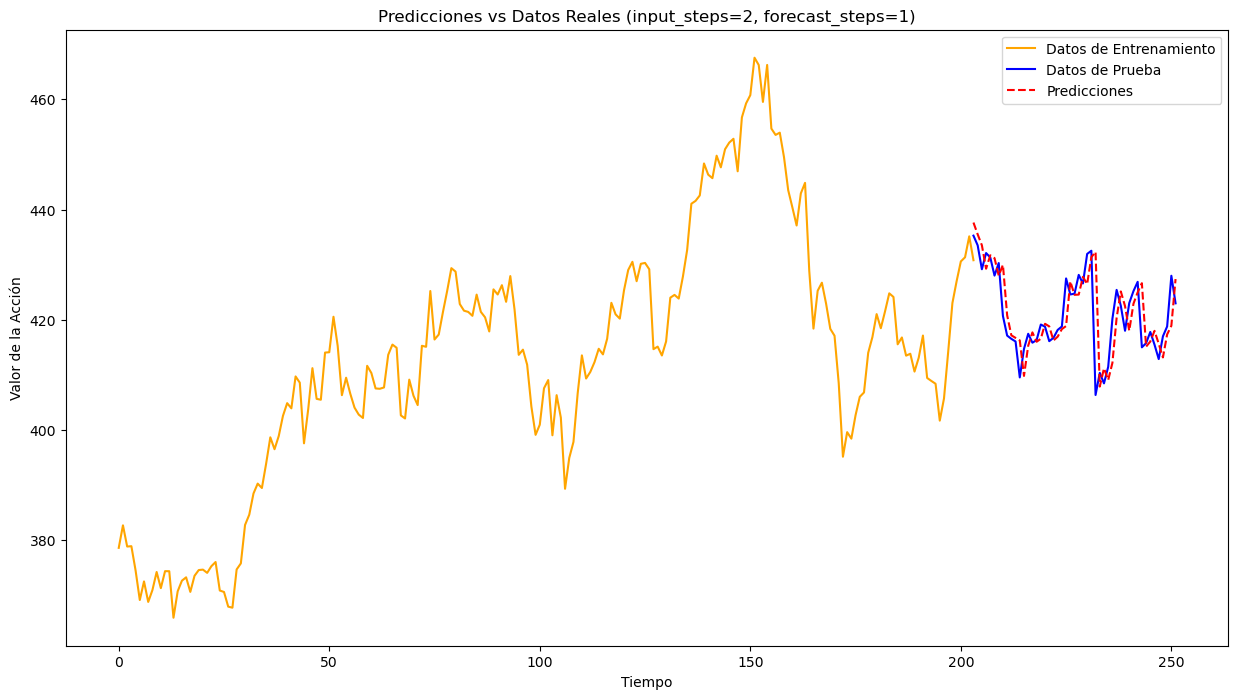

Prediction:  [[427.38907]]
Prediction:  [[470.65448]]
Prediction:  [[494.97128]]


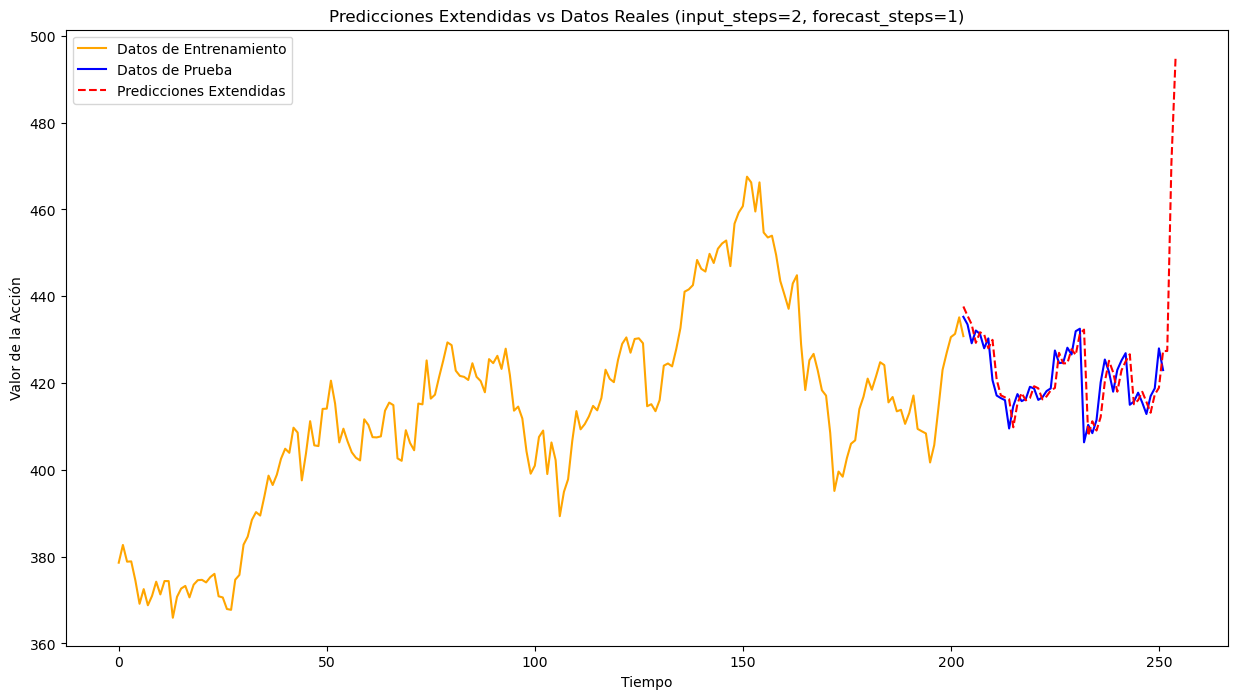

Evaluando configuración: {'input_steps': 2, 'forecast_steps': 2}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
MAE: 4.31943363189697, RMSE: 6.316558424564601


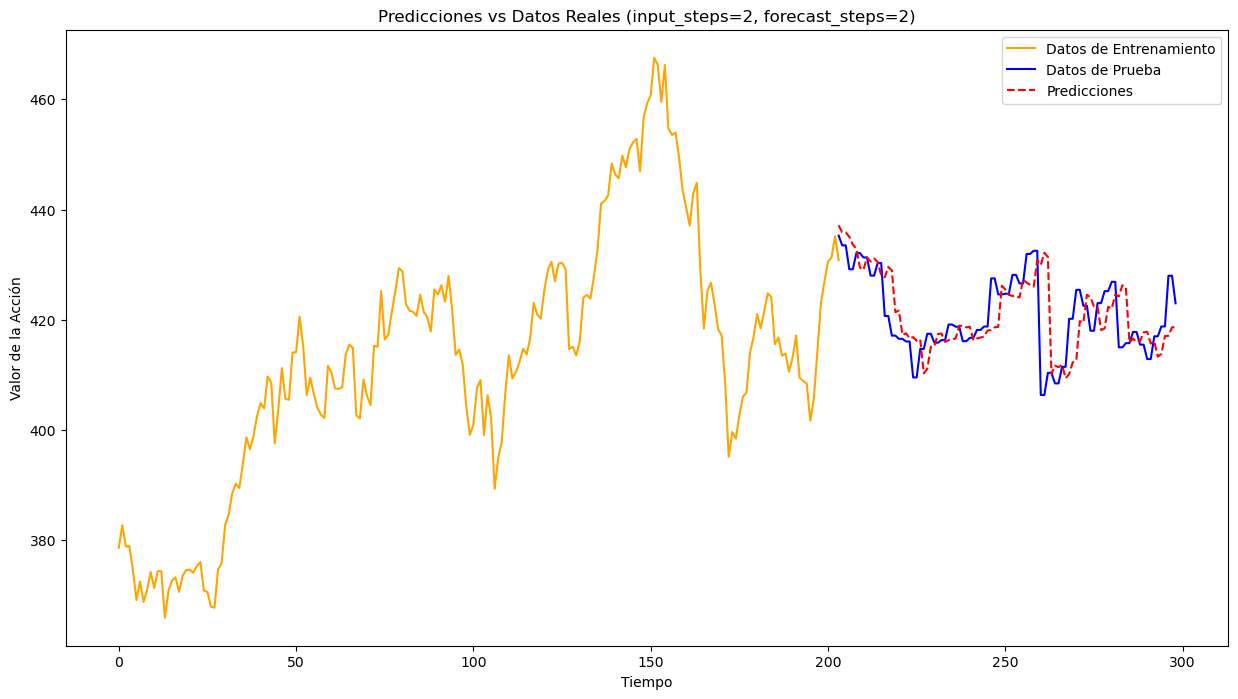

Prediction:  [[418.6252  418.65207]]
Prediction:  [[458.0018  456.88098]]
Prediction:  [[480.64777 483.00742]]


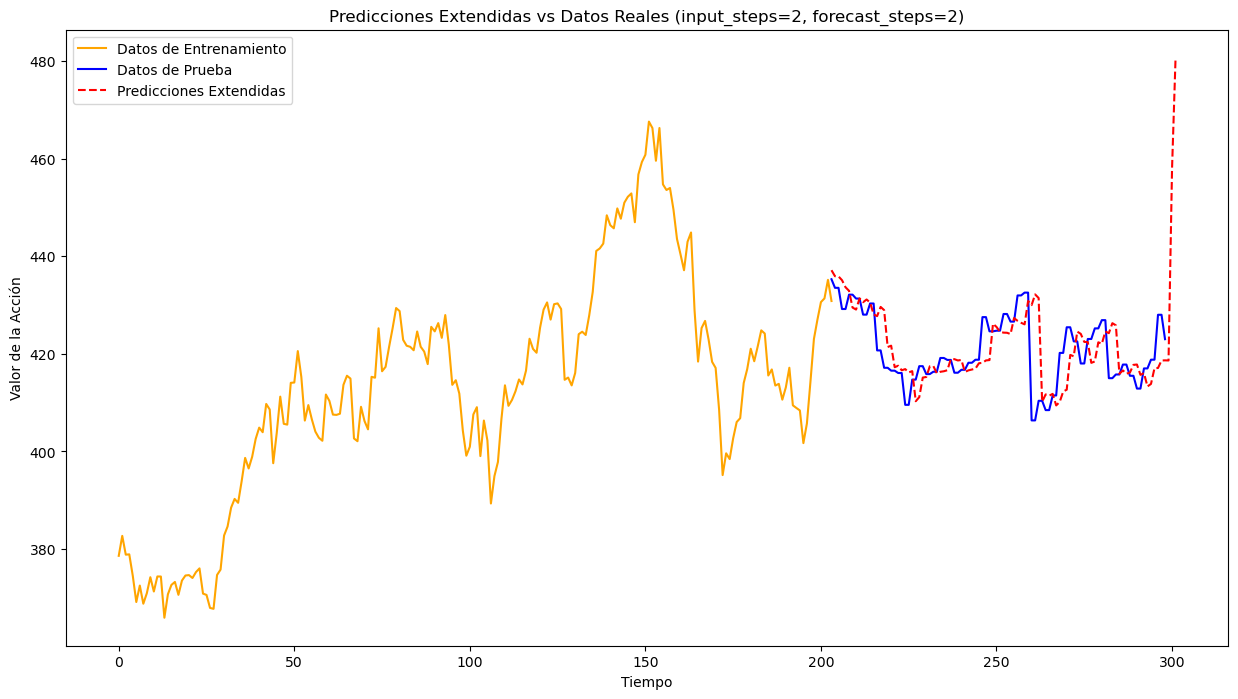

Evaluando configuración: {'input_steps': 4, 'forecast_steps': 1}
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x15e9fab60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
MAE: 3.718871862533242, RMSE: 5.437464745001967


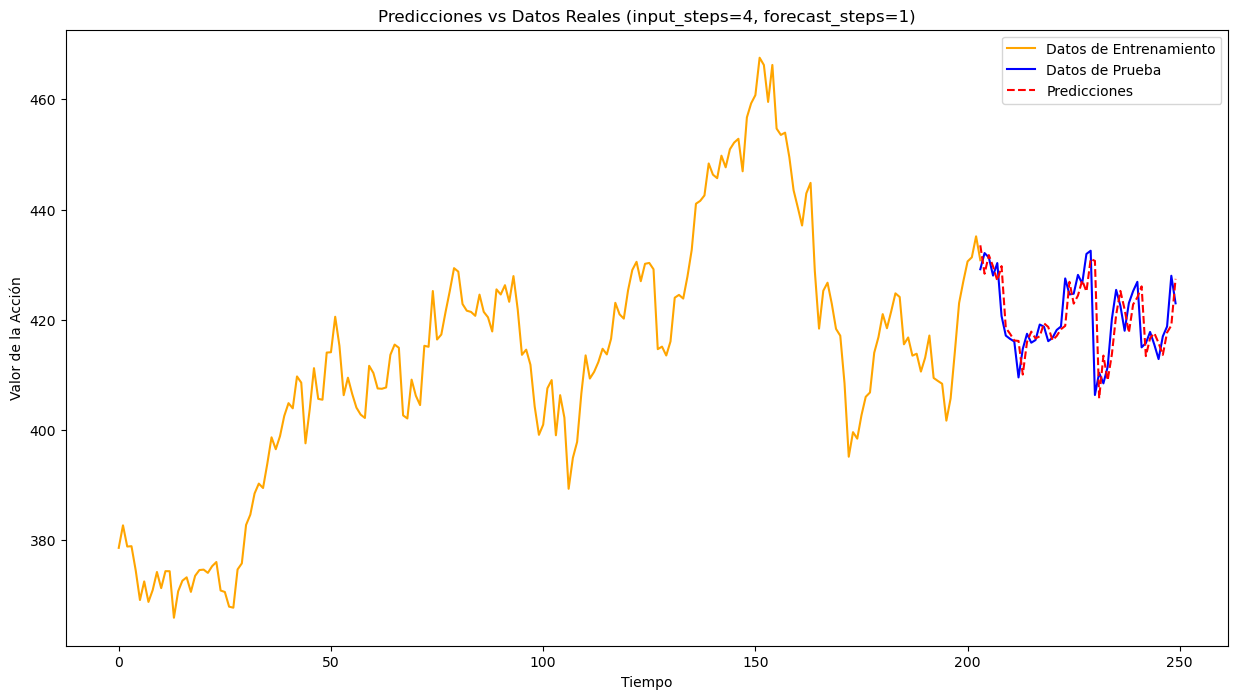

Prediction:  [[427.42896]]
Prediction:  [[454.61462]]
Prediction:  [[460.8054]]


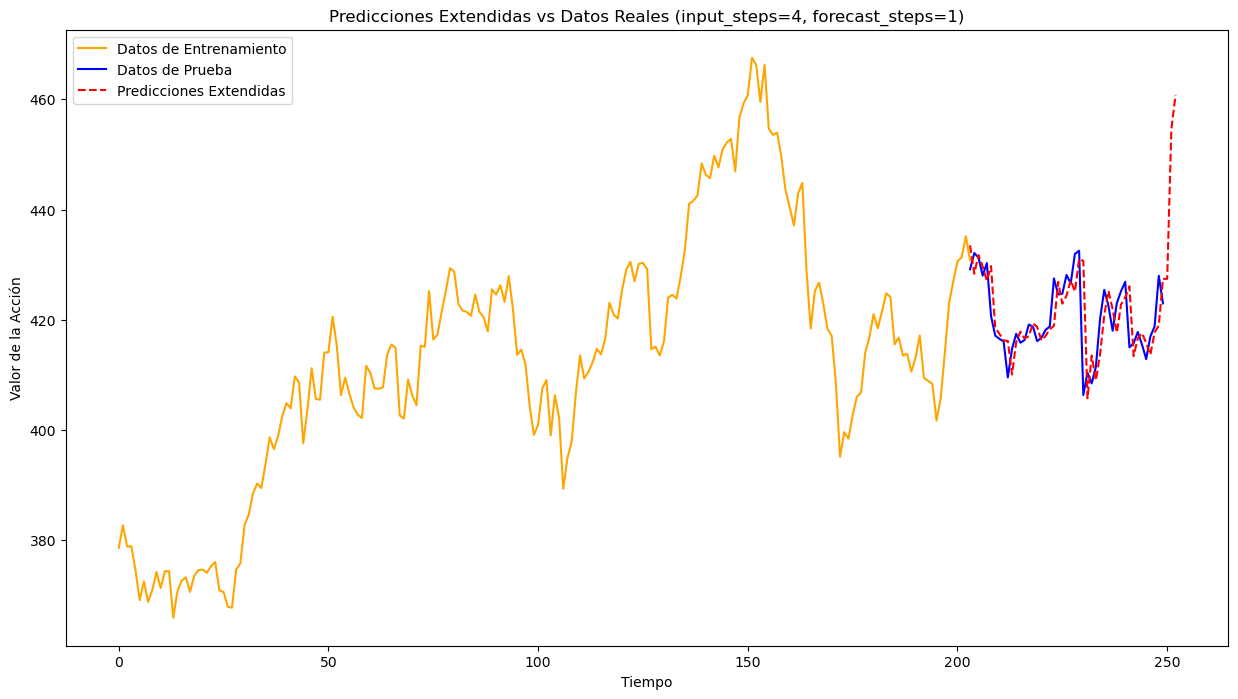

Evaluando configuración: {'input_steps': 4, 'forecast_steps': 2}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
MAE: 4.398446177606994, RMSE: 6.351684884101186


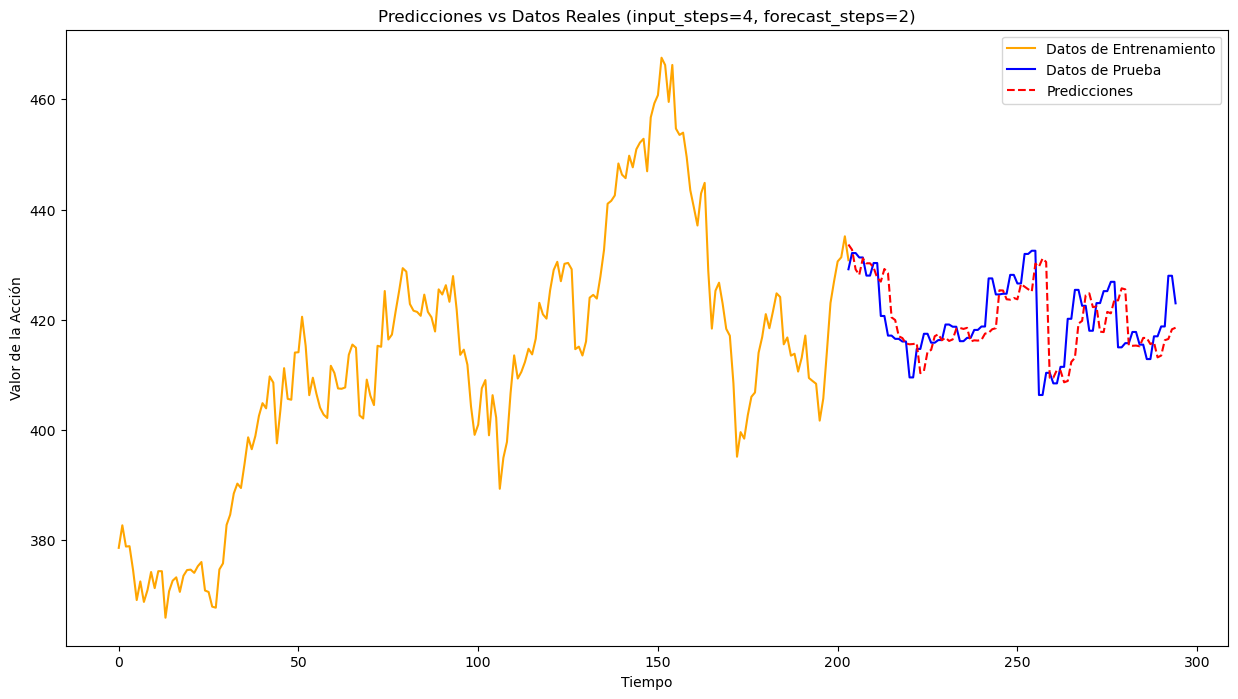

Prediction:  [[418.27805 418.55728]]
Prediction:  [[450.66455 451.10596]]
Prediction:  [[459.80994 460.64276]]


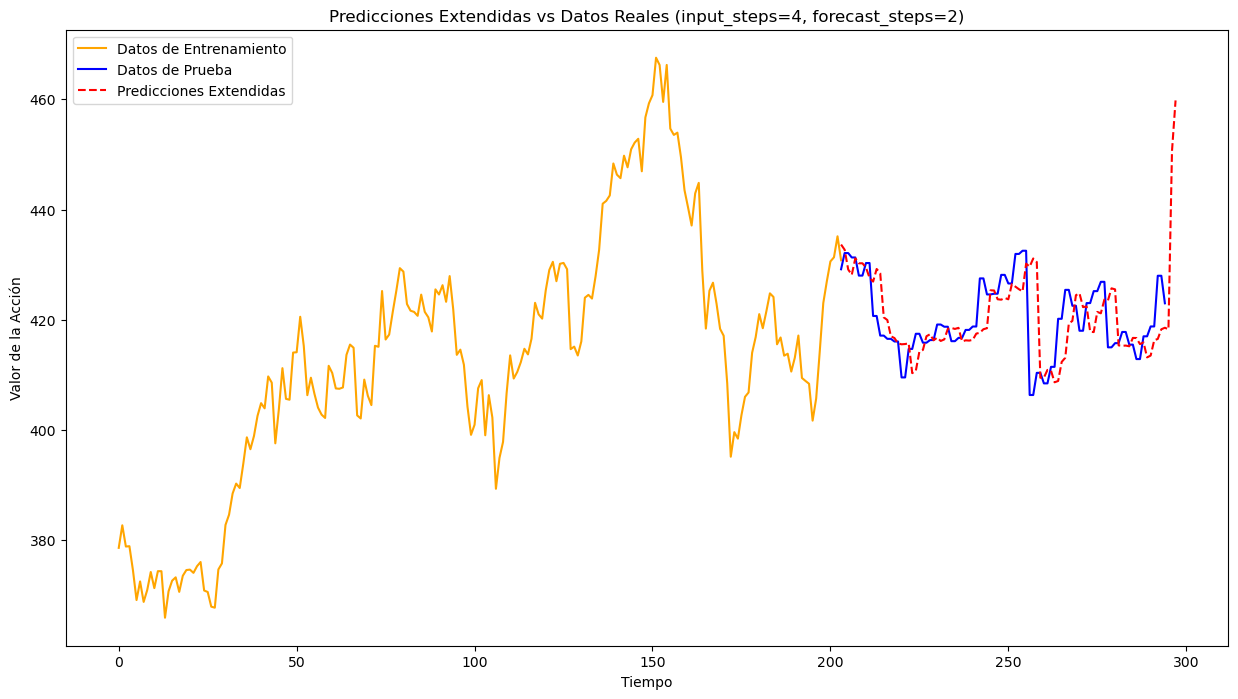

Evaluando configuración: {'input_steps': 10, 'forecast_steps': 1}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
MAE: 3.8567028213128762, RMSE: 5.8111533711706365


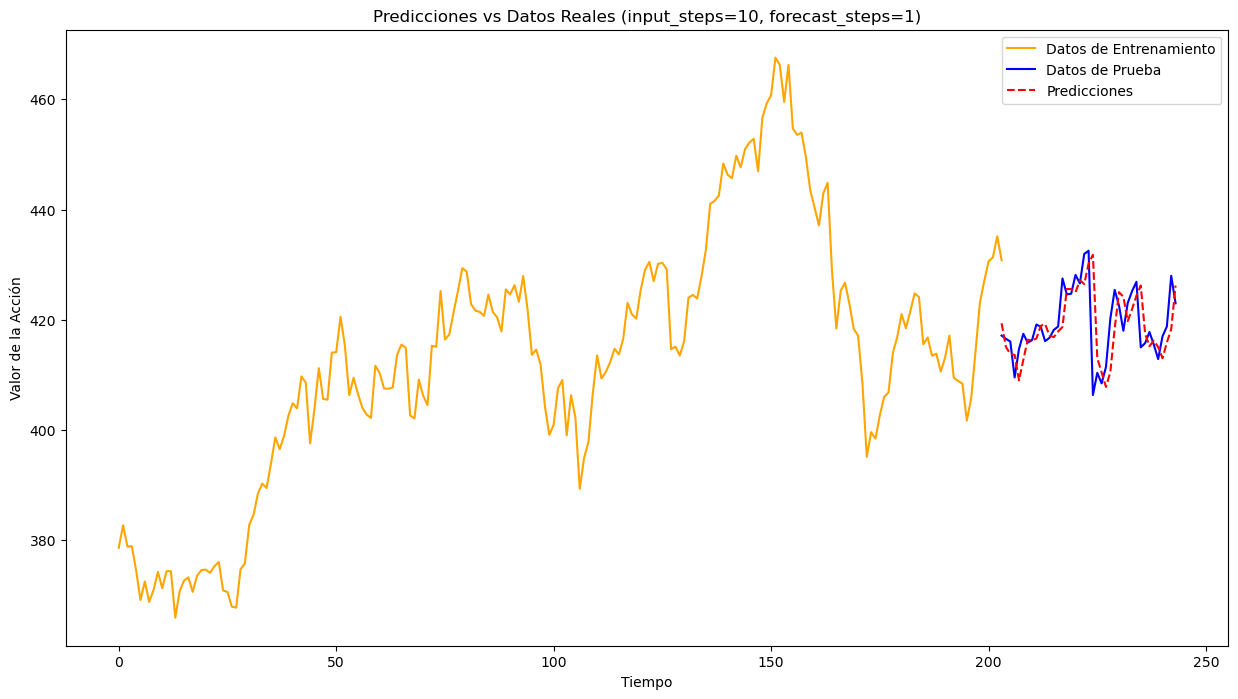

Prediction:  [[426.2173]]
Prediction:  [[465.3482]]
Prediction:  [[474.26572]]


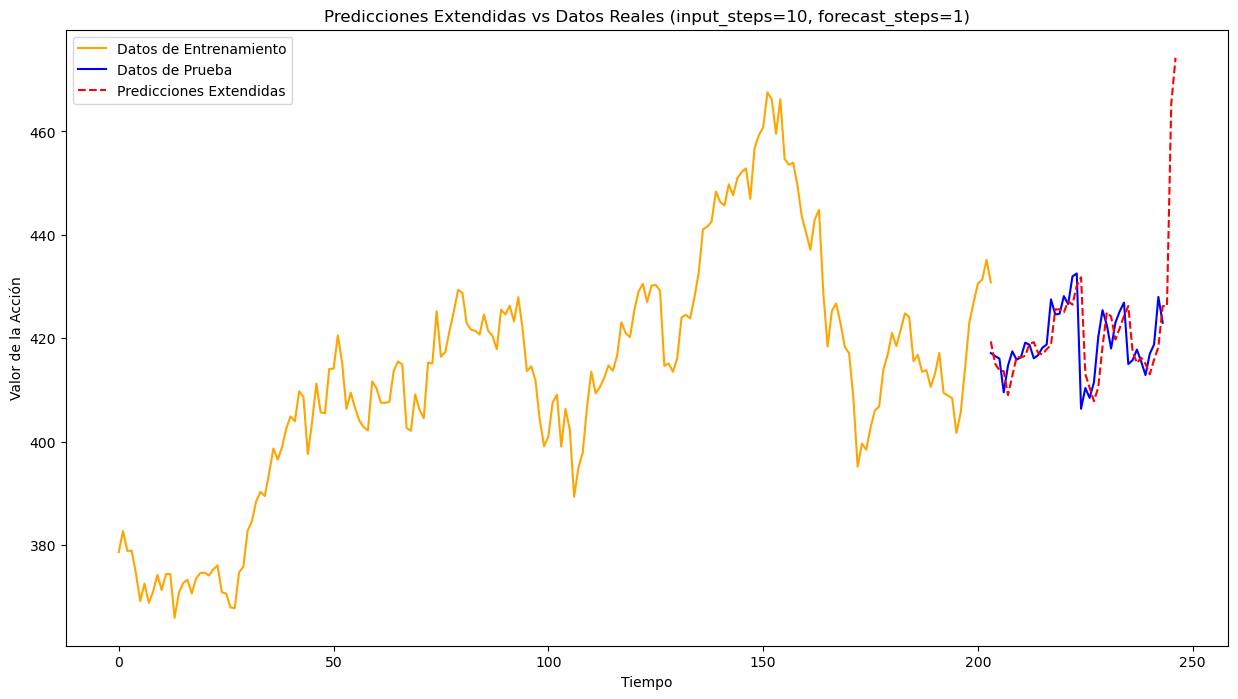

In [30]:
for config in configs:
    print(f"Evaluando configuración: {config}")
    X, y = create_dataset(scaled_msft, config['input_steps'], config['forecast_steps'])
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


    model_lstm = Sequential()

    model_lstm.add(LSTM(units=80, return_sequences=True, input_shape=(config['input_steps'],1)))
    model_lstm.add(Dropout(0.4))
    model_lstm.add(LSTM(units=80, return_sequences=True))
    model_lstm.add(Dropout(0.4))
    model_lstm.add(LSTM(units=80, return_sequences=True))
    model_lstm.add(Dropout(0.4))
    model_lstm.add(LSTM(units=50, return_sequences=False))
    model_lstm.add(Dropout(0.2))
    model_lstm.add(Dense(units=config['forecast_steps'])) 

    model_lstm.compile(loss='mean_squared_error', optimizer='adam')

    model_lstm.fit(X_train, y_train, epochs=200, batch_size=32, verbose=0)

    predictions = model_lstm.predict(X_test)
    
    predictions = predictions.reshape(-1, config['forecast_steps'])

    predictions = predictions.reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions)
    
    X_train_scaled = np.reshape(X_train, (-1, 1)) 
    X_train = scaler.inverse_transform(X_train_scaled)
    y_test_scaled = np.reshape(y_test, (-1, 1))  # Reshape for inverse transform
    y_test = scaler.inverse_transform(y_test_scaled)
    
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    print(f"MAE: {mae}, RMSE: {rmse}")

    
    # Crear un índice de tiempo para X_train y y_train
    train_index = range(train_size + 1)  # Indices for the original training data
    test_index = range(train_size, train_size + len(y_test))  # Indices for the test data
    
    plt.figure(figsize=(15, 8))
    # Plot the original scaled training data (not overlapping windows)
    plt.plot(train_index, scaler.inverse_transform(scaled_msft[:train_size + 1]), label="Datos de Entrenamiento", color='orange')
    
    # Plot the test data
    plt.plot(test_index, y_test[:, 0], label="Datos de Prueba", color='blue')
    
    # Plot the predictions
    plt.plot(test_index, predictions[:, 0], label="Predicciones", color='red', linestyle='--')
    
    # Configure the plot
    plt.legend()
    plt.title(f"Predicciones vs Datos Reales (input_steps={config['input_steps']}, forecast_steps={config['forecast_steps']})")
    plt.xlabel("Tiempo")
    plt.ylabel("Valor de la Acción")
    plt.show()

    # Calcular el índice para los datos futuros
    future_steps = 3  # Número de pasos futuros que deseas predecir
    extended_index = range(train_size, train_size + len(y_test) + future_steps)
    
    # Extender las predicciones más allá de los datos reales
    extended_predictions = np.zeros((len(y_test) + future_steps, config['forecast_steps']))
    extended_predictions[:len(predictions)] = predictions

    # Opcional: para pasos futuros, puedes rellenar con valores extrapolados o continuar con predicciones del modelo
    window_size = 10 
    
    # Reshape the last sequence from the test set
    last_input = X_test[-1].reshape(1, X_test.shape[1], 1)  # Shape: (1, input_steps, 1)
    extended_input = last_input[:, -window_size:, :]
    
    
    # Generate future predictions
    for i in range(future_steps):
        # Predict the next value(s) based on the current rolling window
        future_pred = model_lstm.predict(extended_input, verbose=0)  # Shape: (1, forecast_steps)
        future_pred = scaler.inverse_transform(future_pred)
        print("Prediction: ", future_pred)
    
        # Store the predicted value(s)
        extended_predictions[len(predictions) + i] = future_pred[:, 0]  # Save prediction

        # Update the rolling window by appending the new prediction
        # and keeping only the most recent `input_steps`
        new_input = np.roll(extended_input, -1, axis=1)  # Shift window to the left
        new_input[0, -1, 0] = future_pred[:, 0]  # Add the new prediction to the window
        extended_input = new_input  # Update the rolling window for the next predic
    
    # Graficar los resultados extendidos
    plt.figure(figsize=(15, 8))
    
    # Datos de entrenamiento
    plt.plot(range(train_size + 1), scaler.inverse_transform(scaled_msft[:train_size + 1]), label="Datos de Entrenamiento", color='orange')
    
    # Datos de prueba
    plt.plot(range(train_size, train_size + len(y_test)), y_test[:, 0], label="Datos de Prueba", color='blue')
    
    # Predicciones (reales y extendidas)
    plt.plot(extended_index, extended_predictions[:, 0], label="Predicciones Extendidas", color='red', linestyle='--')
    
    # Configuración del gráfico
    plt.legend()
    plt.title(f"Predicciones Extendidas vs Datos Reales (input_steps={config['input_steps']}, forecast_steps={config['forecast_steps']})")
    plt.xlabel("Tiempo")
    plt.ylabel("Valor de la Acción")
    plt.show()